<a href="https://colab.research.google.com/github/Pakeith0805/SparkPlus_Assignment/blob/staging/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SparkPlusの採用課題です。

- ラベル「0」： airplane（飛行機）
- ラベル「1」： automobile（自動車）
- ラベル「2」： bird（鳥）
- ラベル「3」： cat（猫）
- ラベル「4」： deer（鹿）
- ラベル「5」： dog（犬）
- ラベル「6」： frog（カエル）
- ラベル「7」： horse（馬）
- ラベル「8」： ship（船）
- ラベル「9」： truck（トラック）

# 前処理

In [24]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import CosineAnnealingLR

In [25]:
# ちゃんとgpuになってるか確認。
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [26]:
# 前処理をまとめる
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # ランダムに左右対称にする
    transforms.ColorJitter(), # ランダムに色を変える。
    transforms.RandomRotation(10), # 回転
    transforms.ToTensor(), # 画像をTensorクラスに変えて、チャネルファーストに変えてくれる。
    transforms.Normalize((0.5,), (0.5,)) # 平均、標準偏差を0.5に
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 訓練用データセットと検証用データセットを作成
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
vilidation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

In [27]:
# データを作る。
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(vilidation_dataset, batch_size=32, shuffle=False)

In [28]:
# CNNを実装。
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 32×32の画像が16×16になる。
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 16×16の画像が8×8になる。
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 8×8の画像が4×4になる。
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes) # in_featuresには1次元ベクトルにして渡す。4×4が128個ある。out_featuresは何個に分類するか。
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # x.size(0)はバッチ数を表す。(32, 4×4×128)という形になる。
        x = self.classifier(x)
        return x

In [29]:
# modelを作成
model = CNN(10) # 10はクラス数
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [30]:
# 損失関数とoptimizerを設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4) # weight_decayで重みづけが大きくなりすぎないようにしている。
# CosineAnnealingLRの設定（最大学習率は初期学習率と同じ、最小学習率は0）
n_iterations = len(train_dataloader) * 15 # 15はnum_epochs
scheduler = CosineAnnealingLR(optimizer, T_max=n_iterations, eta_min=0)

In [31]:
# 学習のループ
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    y_true = []  # 正解ラベルを保存
    y_pred = []  # 予測ラベルを保存
    for imgs, labels, in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() # 勾配の初期化
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        prob_pred = torch.softmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
        y_true.extend(labels.cpu().numpy())  # GPU->CPU
        y_pred.extend(pred.cpu().numpy())  # GPU->CPU
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    #accs.append(running_acc)
    accs.append(running_acc.cpu())
    scheduler.step()
#
# validationのループ
#
    val_running_loss = 0.0
    val_running_acc = 0.0
    y_val_true = []  # 正解ラベルを保存
    y_val_pred = []  # 予測ラベルを保存
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
        # ラベルを保存
        y_val_true.extend(val_labels.cpu().numpy())  # GPU->CPU
        y_val_pred.extend(val_pred.cpu().numpy())  # GPU->CPU

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    #val_accs.append(val_running_acc)
    val_accs.append(val_running_acc.cpu())
    print("epoch: {}, loss: {}, acc: {}, \
     val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 1.4483306391530515, acc: 0.4708693325519562,      val loss: 1.1363271046370362, val acc: 0.5970447063446045
epoch: 1, loss: 1.014370167171505, acc: 0.6422744989395142,      val loss: 0.9347020312429617, val acc: 0.6729233264923096
epoch: 2, loss: 0.8581471709738309, acc: 0.697836697101593,      val loss: 0.7834653565868402, val acc: 0.7312300205230713
epoch: 3, loss: 0.7778046510765664, acc: 0.7280270457267761,      val loss: 0.7865246305831324, val acc: 0.7260383367538452
epoch: 4, loss: 0.7258300038670701, acc: 0.7473008632659912,      val loss: 0.6968779588659731, val acc: 0.7613818049430847
epoch: 5, loss: 0.6860618336568334, acc: 0.7604366540908813,      val loss: 0.6890853891452662, val acc: 0.7559903860092163
epoch: 6, loss: 0.6561214603145231, acc: 0.769793689250946,      val loss: 0.6970214153916691, val acc: 0.7681708931922913
epoch: 7, loss: 0.6334310492222994, acc: 0.7792906165122986,      val loss: 0.6532928565630136, val acc: 0.7762579917907715
epoch: 8, l

In [32]:
labels

tensor([3, 1, 8, 6, 7, 4, 8, 1, 4, 7, 9, 5, 4, 8, 8, 4], device='cuda:0')

In [33]:
one_zero_labels = torch.where(labels == 0, 1, 0)
print(one_zero_labels)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


In [34]:
prob = prob_pred[:, 0]

In [35]:
prob
# probはラベル0の確率。これ使ってroc曲線かける

tensor([1.4079e-08, 1.2247e-04, 3.6989e-02, 7.8139e-08, 1.9189e-04, 1.2808e-01,
        3.3687e-02, 3.1899e-08, 2.9156e-08, 1.1438e-02, 8.9228e-03, 2.7844e-01,
        3.6567e-05, 4.4495e-03, 3.2683e-03, 1.2942e-03], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [36]:
roc = roc_curve(one_zero_labels.cpu().detach().numpy(), prob.cpu().detach().numpy())

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [37]:
fpr, tpr, thresholds = roc

print(fpr)
# [0.   0.   0.25 0.25 0.5  0.5  1.  ]

print(tpr)
# [0.   0.25 0.25 0.5  0.5  1.   1.  ]

print(thresholds)
# [1.9 0.9 0.8 0.7 0.6 0.4 0.2]

[0.     0.0625 1.    ]
[nan nan nan]
[          inf 2.7843976e-01 1.4078824e-08]


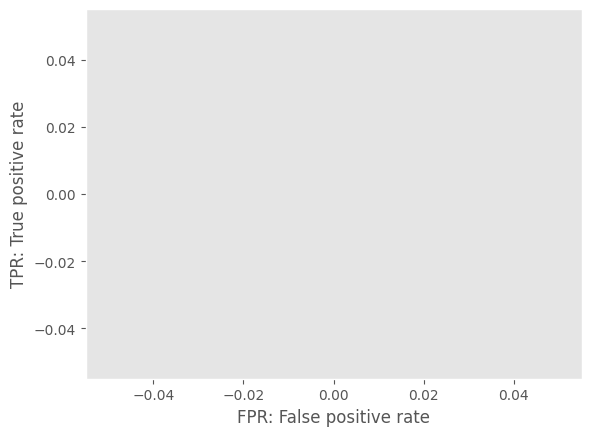

In [38]:
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

# 評価項目

In [39]:
# 正解率
print(accs[-1].cpu())
print(val_accs[-1].cpu())
# 混同行列
cm=confusion_matrix(y_true, y_pred)
val_cm=confusion_matrix(y_val_true, y_val_pred)
print(cm)
print(val_cm)
# 再現率：実際に真だったもののうち、モデルが真と判断した割合。
# 見逃しをなくしたいときに使われる。
# 別名真陽性率。
recall_per_class = cm.diagonal() / cm.sum(axis=1)
val_recall_per_class = val_cm.diagonal() / val_cm.sum(axis=1)
print(recall_per_class)
print(val_recall_per_class)
# 適合率：モデルが真と判断し、実際に真だった割合。猫と判断し、実際に猫だった割合。
# 誤検出をなくしたいときに使われる。
precision_per_class = cm.diagonal() / cm.sum(axis=0)
val_precision_per_class = val_cm.diagonal() / val_cm.sum(axis=0)
print(precision_per_class)
print(val_precision_per_class)
# F1スコア：適合率と再現率の調和平均。
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)
val_f1_per_class = 2 * (val_precision_per_class * val_recall_per_class) / (val_precision_per_class + val_recall_per_class)
print(f1_per_class)
print(val_f1_per_class)
# 偽陽性率：実際に偽だったったもののうち、モデルが間違えて真と判断した割合。

tensor(0.8126)
tensor(0.8010)
[[4152   50  181   95   75   27   27   55  235  103]
 [  62 4520   18   21   11   14   24   10   83  237]
 [ 230   12 3718  213  273  168  207  107   43   29]
 [  78   20  224 3349  212  633  239  137   60   48]
 [  86    4  227  194 3994  118  136  198   21   22]
 [  29   13  201  722  164 3559   94  172   18   28]
 [  34   21  188  211  119   95 4267   18   29   18]
 [  47    6  104  139  208  201   27 4215   12   41]
 [ 229   80   46   43   24   10   15   13 4456   84]
 [ 110  245   25   40    7   18   25   42   89 4399]]
[[854   8  22  20   4   3   5   8  46  30]
 [ 11 849   3   6   2   4   2   0  18 105]
 [ 58   4 701  50  69  39  38  22   8  11]
 [ 29   4  37 710  44  96  30  25   9  16]
 [ 16   1  39  75 749  27  26  58   5   4]
 [ 13   1  35 178  20 680  11  47   4  11]
 [ 11   6  32  64  21  15 841   6   1   3]
 [ 16   1  20  38  27  25   1 860   3   9]
 [ 58  16   8  11   1   1   3   3 868  31]
 [ 16  26   5  16   3   4   3   8  19 900]]
[0.8304 

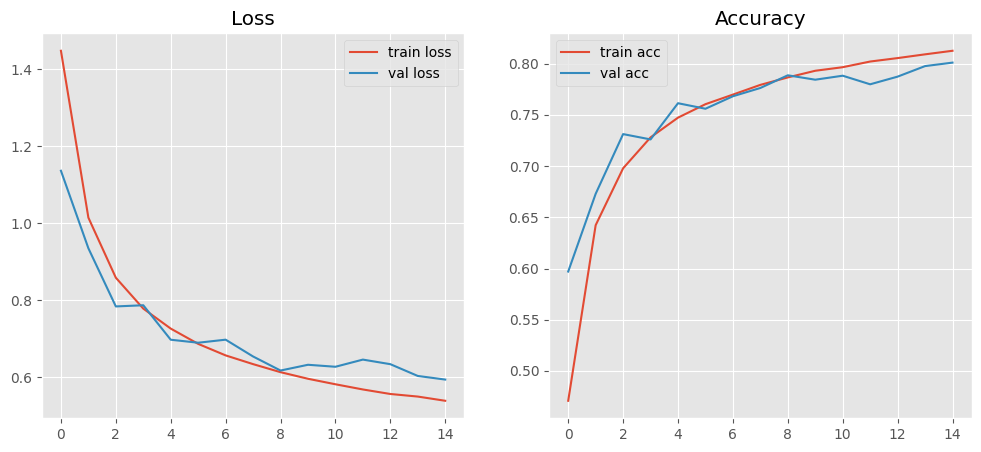

In [40]:
plt.style.use("ggplot")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1行2列のサブプロット

# 左のグラフ(損失)
axes[0].plot(losses, label="train loss")
axes[0].plot(val_losses, label="val loss")
axes[0].legend()
axes[0].set_title("Loss")

# 右のグラフ(精度)
axes[1].plot(accs, label="train acc")
axes[1].plot(val_accs, label="val acc")
axes[1].legend()
axes[1].set_title("Accuracy")

plt.show()

In [41]:
print(accs)
print(val_accs)

[tensor(0.4709), tensor(0.6423), tensor(0.6978), tensor(0.7280), tensor(0.7473), tensor(0.7604), tensor(0.7698), tensor(0.7793), tensor(0.7866), tensor(0.7931), tensor(0.7965), tensor(0.8021), tensor(0.8054), tensor(0.8091), tensor(0.8126)]
[tensor(0.5970), tensor(0.6729), tensor(0.7312), tensor(0.7260), tensor(0.7614), tensor(0.7560), tensor(0.7682), tensor(0.7763), tensor(0.7886), tensor(0.7843), tensor(0.7882), tensor(0.7799), tensor(0.7873), tensor(0.7976), tensor(0.8010)]


In [42]:
# y_val_true はラベル（0 or 1）を含むリスト
y_val_true = torch.tensor(y_val_true)

# val_output に softmax を適用
val_output_tensor = torch.cat([model(val_imgs.to(device)) for val_imgs, _ in validation_dataloader])
val_prob_pred = torch.softmax(val_output_tensor, dim=1)

# クラス0の確率値を取得
prob = val_prob_pred[:, 0].cpu().detach().numpy()

# 0/1 ラベルの取得
one_zero_labels = torch.where(y_val_true == 0, 1, 0).cpu().detach().numpy()

# ROC曲線の計算
fpr, tpr, thresholds = roc_curve(one_zero_labels, prob)

# グラフ描画
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False Positive Rate')
plt.ylabel('TPR: True Positive Rate')
plt.grid()
plt.show()


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 2509 has 14.73 GiB memory in use. Of the allocated memory 14.52 GiB is allocated by PyTorch, and 75.35 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
def make_roc_curve():
    fig, axes = plt.subplots(5, 2, figsize=(12, 25))  # 5行2列のサブプロット

    for n in range(10):

        # クラス0の確率値を取得
        prob = val_prob_pred[:, n].cpu().detach().numpy()

        # 0/1 ラベルの取得
        one_zero_labels = torch.where(y_val_true == n, 1, 0).cpu().detach().numpy()

        # ROC曲線の計算
        fpr, tpr, thresholds = roc_curve(one_zero_labels, prob)

        # auc算出
        auc_score = roc_auc_score(one_zero_labels, prob)
        print(f"ROC AUC Score: {auc_score:.4f}")

        # 行インデックスと列インデックスの計算
        row_idx = n // 2  # 行インデックス
        col_idx = n % 2   # 列インデックス

        # グラフ描画
        axes[row_idx, col_idx].plot(fpr, tpr, marker='o', color='b', label="ROC Curve")
        axes[row_idx, col_idx].set_xlabel('FPR: False Positive Rate')
        axes[row_idx, col_idx].set_ylabel('TPR: True Positive Rate')
        axes[row_idx, col_idx].set_title(f'ROC Curve - Class {n}')
        axes[row_idx, col_idx].legend()
        axes[row_idx, col_idx].grid()
    plt.tight_layout()
    plt.show()

make_roc_curve()